# Домашнее задание 2

Используя датасет [STUDENT ALCOHOL CONSUMPTION](https://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION#) и статью "USING	DATA	MINING	TO	PREDICT	SECONDARY SCHOOL	STUDENT	ALCOHOL	CONSUMPTION" выполните следующие задания:

### Предобработка (Max 2)
- Приведите описание признаков датасета на русском языке с указанием типа данных (0.3 балла)
- Предобработка данных (1.7)
    - Проверьте наличие пропусков. В случае наличия пропусков заполните их медианными значениями (0.4)
    - Подсчитайте количество людей, у которых матери с образованием "0" (0.4)
    - Преобразуйте все номинальные признаки в несколько признаков с бинарным значение (0.4)
    - Используя объект [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) с параметром [f_regression](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)  выберите два признака, которые наиболее сильно связаны с признаком G3 (0.5)

In [363]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Regressors. 
#
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10, 6)

In [302]:
# Зададим seed
#
RANDOM_SEED = 4118956
np.random.RandomState(RANDOM_SEED)

In [111]:
df_stud_m = pd.read_csv('./student-mat.csv', sep=';')
df_stud_p = pd.read_csv('./student-por.csv', sep=';')

In [112]:
df_stud_m['subj'] = 0
df_stud_p['subj'] = 1

In [113]:
df = pd.concat([df_stud_m, df_stud_p], ignore_index=True)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subj
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,0
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,0


### Описание признаков


* school - школа учащегося (бинарный признак: 'GP' - Gabriel Pereira, 'MS' - Mousinho da Silveira) 
* sex - пол учащегося (бинарный: 'F' - женский, 'M' - мужской) 
* age - возраст учащегося (вещественный: от 15 до 22) 
* address - тип домашнего адреса учащегося (бинарный: 'U' - городской или 'R' - загородный) 
* famsize - размер семьи (бинарный: 'LE3' - меньше или равный 3 или 'GT3' - больше чем 3) 
* Pstatus - статус сожительства родителей (бинарный: 'T' - живут вместе или 'A' - раздельно) 
* Medu - образование матери (вещественный: 0 - нет, 1 - начальное образование (4ый класс), 2 - от 5го до 9го класса, 3 - среднее образование или 4 - высшее образование) 
* Fedu - образование отца (вещественный: 0 - нет, 1 - начальное образование (4ый класс), 2 - от 5го до 9го класса, 3 - среднее образование или 4 - высшее образование) 
* Mjob - работа матери (категориальный: учитель - 'teacher', относится к здравоохранению - 'health', государственная служба (e.g. чиновник или в полиции) - 'services', домохозяйка - 'at_home' или другое - 'other') 
* Fjob - работа отца (категориальный: учитель - 'teacher', относится к здравоохранению - 'health', государственная служба (e.g. чиновник или в полиции) - 'services', домохозяйка - 'at_home' или другое - 'other') 
* reason - причина выбора школы (категориальный: близко к дому - 'home', репутация школы - 'reputation', предпочтение предметов - 'course' или другое - 'other') 
* guardian - опекун учащегося (категориальный: мать - 'mother', отец - 'father' или другое - 'other') 
* traveltime - время дороги от дома до школы (вещественный: 1 - <15 мин., 2 - от 15 до 30 мин., 3 - от 30 мин. до 1 часа, или 4 - >1 часа) 
* studytime - количество времени на учебу в неделю (вещественный: 1 - <2 часов, 2 - от 2 до 5 часов, 3 - от 5 до 10 часов, или 4 - >10 часов) 
* failures - количество незачетов в прошлом (вещественный: n, если 1<=n<3, в ином случае 4) 
* schoolsup - дополнительная образовательная поддержка в школе (бинарный: yis или no) 
* famsup - дополнительная образовательная поддержка в семье (бинарный: yes или no)  
* paid - дополнительные платные уроки по предмету (математика или португальский) (бинарный: yes или no)  
* activities - внеклассные занятия (бинарный: yes или no) 
* nursery - посещал ли детский сад (бинарный: yes или no)  
* higher - хочет ли получить высшее образование (бинарный: yes или no) 
* internet - доступ к интернету дома (бинарный: yes или no)  
* romantic - есть ли романтические отношения (бинарный: yes или no)  
* famrel - качество отношений в семье (вещественный: от 1 - очень плохие до 5 - отличные) 
* freetime - свободное время после школы (вещественный: от 1 - очень мало до 5 - очень много) 
* goout - сколько времени проводит с друзьями (вещественный: от 1 - очень мало до 5 - очень много)  
* Dalc - потребление алкоголяля в будни (вещественный: от 1 - очень мало до 5 - очень много) 
* Walc - потребление алкоголя на выходных (вещественный: от 1 - очень мало до 5 - очень много)  
* health - состояние здоровья (вещественный: от 1 - очень плохое до 5 - очень хорошее) 
* absences - количество пропусков занятий (вещественный: от 0 до 93) 

---

Эти оценки относятся к предмету - математике или португальскому. 
* G1 - оценка за первую четверть (вещественный: от 0 до 20) 
* G2 - оценка за вторую четверть (вещественный: от 0 до 20) 
* G3 - итоговая оценка (вещественный: от 0 до 20, цель предсказания) 


In [114]:
# Ищем пропуски в датафрейме.
#
True in df.isnull() 

False

In [115]:
# Образование матери = 0.
#
len(df.loc[df['Medu'] == 0, :])

9

In [116]:
# Преобразуем бинарные строковые признаки в бинарные int признаки.
#
def convert_to_binary(series):
    res = []
    one_var = series[0]
    for i in series:
        if i == one_var:
            res.append(0)
        else:
            res.append(1)
    return pd.Series(res)

In [117]:
binary_things = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 
 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for thing in binary_things:
    df[thing] = convert_to_binary(df[thing])

In [118]:
df = pd.get_dummies(df, columns = ['Mjob', 'Fjob', 'reason', 'guardian'])

In [119]:
# Добились того, что нет номинальных признаков.
#
df.dtypes

school               int64
sex                  int64
age                  int64
address              int64
famsize              int64
Pstatus              int64
Medu                 int64
Fedu                 int64
traveltime           int64
studytime            int64
failures             int64
schoolsup            int64
famsup               int64
paid                 int64
activities           int64
nursery              int64
higher               int64
internet             int64
romantic             int64
famrel               int64
freetime             int64
goout                int64
Dalc                 int64
Walc                 int64
health               int64
absences             int64
G1                   int64
G2                   int64
G3                   int64
subj                 int64
Mjob_at_home         uint8
Mjob_health          uint8
Mjob_other           uint8
Mjob_services        uint8
Mjob_teacher         uint8
Fjob_at_home         uint8
Fjob_health          uint8
F

In [135]:
# Выбираем 2 признака, наиболее связанных с G3.
#
def choose_feature(n_features):
    skb = SelectKBest(score_func=f_regression, k=n_features)
    skb.fit_transform(df.drop('G3',axis=1), df['G3'])
    indices = skb.get_support(indices=True)
    for i in indices:
        print(df.iloc[:, i].name)

In [138]:
choose_feature(n_features=2)

G1
G2


### Регрессия (Max 4)
Выберите один признак, который наиболее влияет на признак G3 и используя кросс-валидацию (cross-validation) выполните следующее:

- На обучающей выборке обучите объект [RidgeСV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для различных alpha (0.2)
- Выберите alpha при котором RidgeCV лучше всего предсказывает значения (0.1)
- Подсчитайте метрику mean absolute error, mean squared error, median absolute error,r2 score(0.2)
- Max (0.5)
- ------------------------------------
- Создайте объекты [SGDRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor), используя все возможных варианты аргумента penalty (0.2)
- Обучите все полученных объекты на обучающей выборке (0.1)
- Подсчитайте метрику r2 score для всех объектов (0.2)
- Max (0.5)
- ------------------------------------
- Создайте объекты с параметрами max_depth = 1,3, 10 [GradientBoostingRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) и для каждого объекта изменяйте количество n_estimators  от 100 до 1000 с шагом 100 (0.2)
- Подсчитайте метрику r2 score для всех объектов (0.1)
- Визуализируйте зависимость R2 oт n_estimators на графике (0.2)
- Max (0.5)
- -----------------------------------
- Используя все доступные регрессоры в библиотеке sklearn, найдите самый лучший регрессор. (2.5)

In [140]:
# Выбираем признак с наибольшим влиянием на G3.
#
choose_feature(n_features=1)

G2


### Регрессия

In [155]:
x_ = SelectKBest(score_func=f_regression, k=1).fit_transform(df.drop('G3',axis=1), df['G3'])

X_train, X_test, y_train, y_test = train_test_split(np.array(x_), np.array(df['G3']), random_state=RANDOM_SEED)

### RidgeCV

In [178]:
alphas = np.logspace(-4, 2, 10)
alphas

array([  1.00000000e-04,   4.64158883e-04,   2.15443469e-03,
         1.00000000e-02,   4.64158883e-02,   2.15443469e-01,
         1.00000000e+00,   4.64158883e+00,   2.15443469e+01,
         1.00000000e+02])

In [179]:
rcv = RidgeCV(alphas=alphas)

In [182]:
rcv.fit(X_train, y_train)

# Лучшая alpha.
#
rcv.alpha_

4.6415888336127722

In [186]:
y_predicted = rcv.predict(X_test)

In [239]:
print('''
        MAE\t= {mae:5.5f}
        MSE\t= {mse:5.5f}
        MDAE\t= {mdae:5.5f}
        R2\t= {r2:5.5f}
      '''.format(mae=mean_absolute_error(y_predicted, y_test),
                 mse=mean_squared_error(y_predicted, y_test),
                 mdae=median_absolute_error(y_predicted, y_test),
                 r2=r2_score(y_predicted, y_test)))


        MAE	= 0.87696
        MSE	= 2.33344
        MDAE	= 0.66507
        R2	= 0.81675
      


## SGDRegressor

In [240]:
penalties = ['none', 'l2', 'l1', 'elasticnet']

In [255]:
for p in penalties:
    # max_iter=5, tol=None parameters are the default ones for 0.19 version, but would be different in 0.21
    # So setting them to '5' and 'None' respectively.
    #
    sgdr = SGDRegressor(penalty=p, max_iter=5, tol=None, random_state=RANDOM_SEED)
    sgdr.fit(X_train, y_train)
    r2score = r2_score(sgdr.predict(X_test), y_test)
    print('Penalty {p: <11} R2 error = {r:1.5f}'.format(p=p, r=r2score))

Penalty none        R2 error = 0.80389
Penalty l2          R2 error = 0.80180
Penalty l1          R2 error = 0.79138
Penalty elasticnet  R2 error = 0.80332


## GBRegressor

In [267]:
max_depths = [1, 3, 10]

In [266]:
def illustrate_r2_score(max_depths, n_ests, verbose=False):
    for md in max_depths:
        scores = []
        for n_est in n_ests:
            gbr = GradientBoostingRegressor(max_depth=md, n_estimators=n_est, random_state=RANDOM_SEED)
            r2score = r2_score(gbr.fit(X_train, y_train).predict(X_test), y_test)
            scores.append(r2score)
            if verbose:
                print('max_depth = {md}, n_estimators = {ne}\t r2 = {r2:3.5f}'.format(md=md, ne=n_est, r2=r2score))
        plt.plot(n_ests, scores, label='max_depth={}'.format(md))
        scores = []

    plt.title('R2 dependency on n_estimators')
    plt.xlabel('n_estimators')
    plt.ylabel('R2 score')
    plt.legend()
    plt.show()

max_depth = 1, n_estimators = 100	 r2 = 0.80334
max_depth = 1, n_estimators = 200	 r2 = 0.80917
max_depth = 1, n_estimators = 300	 r2 = 0.80939
max_depth = 1, n_estimators = 400	 r2 = 0.80940
max_depth = 1, n_estimators = 500	 r2 = 0.80940
max_depth = 1, n_estimators = 600	 r2 = 0.80940
max_depth = 1, n_estimators = 700	 r2 = 0.80940
max_depth = 1, n_estimators = 800	 r2 = 0.80940
max_depth = 1, n_estimators = 900	 r2 = 0.80940
max_depth = 1, n_estimators = 1000	 r2 = 0.80940
max_depth = 3, n_estimators = 100	 r2 = 0.80939
max_depth = 3, n_estimators = 200	 r2 = 0.80940
max_depth = 3, n_estimators = 300	 r2 = 0.80940
max_depth = 3, n_estimators = 400	 r2 = 0.80940
max_depth = 3, n_estimators = 500	 r2 = 0.80940
max_depth = 3, n_estimators = 600	 r2 = 0.80940
max_depth = 3, n_estimators = 700	 r2 = 0.80940
max_depth = 3, n_estimators = 800	 r2 = 0.80940
max_depth = 3, n_estimators = 900	 r2 = 0.80940
max_depth = 3, n_estimators = 1000	 r2 = 0.80940
max_depth = 10, n_estimators = 100	 r2

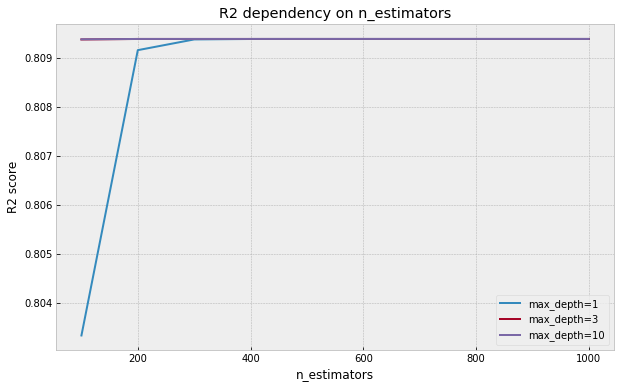

In [268]:
illustrate_r2_score(max_depths=max_depths, n_ests=np.arange(100, 1001, 100), verbose=True)

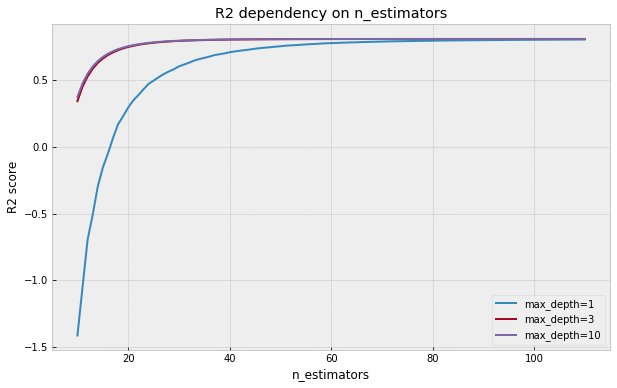

In [280]:
# Попробуем другие значения параметра n_estimarots - этот график нагляднее иллюсрирует изменение r2 score.
#
illustrate_r2_score(max_depths=max_depths, n_ests=np.arange(10, 111, 1))

### Найдем лучший регрессор в scikit-learn

In [ ]:
# Регрессоры. Изначально я брал вообще все регрессоры из sklearn API reference, но потом уточнил у семинариста.
# Он сказал, что достаточно пяти любых. 
#
regressors = [AdaBoostRegressor(random_state=RANDOM_SEED), 
              BaggingRegressor(random_state=RANDOM_SEED), 
              RandomForestRegressor(random_state=RANDOM_SEED), 
              GradientBoostingRegressor(random_state=RANDOM_SEED), 
              MLPRegressor(random_state=RANDOM_SEED), 
              DecisionTreeRegressor(random_state=RANDOM_SEED)]

In [365]:
res = {}

In [368]:
for reg in regressors:
    reg_name= reg.__class__.__name__
    score = reg.fit(X_train, y_train).score(X_test, y_test)
    res[reg_name] = score
    print('{reg: <27} score:  {sc:4.5f}'.format(reg=reg_name, sc=score))

AdaBoostRegressor           score:  0.77671
BaggingRegressor            score:  0.81800
RandomForestRegressor       score:  0.81804
GradientBoostingRegressor   score:  0.81955
MLPRegressor                score:  0.83033
DecisionTreeRegressor       score:  0.81954


In [369]:
max_reg = max(res)
print('Max score ({s:2.5}) has {r}!'.format(s=res[max_reg], r=max_reg))

Max score (0.81804) has RandomForestRegressor!


### Классификация (Max 4)
- В статье описано использование Random Forest для предсказания важности факторов, влияющих на потребление алкоголя. Повторите эксперимент с использование объекта [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) и найдите наилучшие параметры. Укажите accuracy для наилучших параметров (0.5)
- Обучите объект [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)  и найдите для него наилучшие параметры. Укажите accuracy для наилучших параметров (0.5)
- Обучите объект [AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)  и найдите для него наилучшие параметры. Укажите accuracy для наилучших параметров (0.5)
- Найдите наилучший классификатор. Укажите accuracy для наилучших параметров (2.5)